# Capstone Project: Windpower Generation Forecasting #

[Click here for a link to the original data set.](https://www.kaggle.com/datasets/theforcecoder/wind-power-forecasting)

Problem: How much wind power will one wind mill generate over the next 15 days?

In [1]:
# Import needed programs and packages
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime,timedelta
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from math import sqrt
import itertools
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, train_test_split 
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [2]:
# Import data as a pandas dataframe
df = pd.read_csv('df.csv')

In [3]:
# View first 5 rows of data
df.head()

,Timestamp,ActivePower,AmbientTemperatue,BearingShaftTemperature,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,GeneratorWinding1Temperature,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WindDirection,WindSpeed
0,2018-01-01 00:00:00+00:00,-5.357727,23.148729,43.010189,64.23417,57.561217,1102.026269,72.460403,71.826659,36.897978,39.547603,8.000000,-9.960830,9.9075,2280.429214,8.000000,2.279088
1,2018-01-01 00:10:00+00:00,-5.822360,23.039754,43.010189,64.23417,57.561217,1102.026269,72.460403,71.826659,36.897978,39.547603,300.428571,-9.628441,9.9075,2280.429214,300.428571,2.339343
2,2018-01-01 00:20:00+00:00,-5.279409,22.948703,43.010189,64.23417,57.561217,1102.026269,72.460403,71.826659,36.897978,39.547603,340.000000,-9.491235,9.9075,2280.429214,340.000000,2.455610
3,2018-01-01 00:30:00+00:00,-4.648054,22.966851,43.010189,64.23417,57.561217,1102.026269,72.460403,71.826659,36.897978,39.547603,345.000000,-9.856136,9.9075,2280.429214,345.000000,2.026754
4,2018-01-01 00:40:00+00:00,-4.684632,22.936520,43.010189,64.23417,57.561217,1102.026269,72.460403,71.826659,36.897978,39.547603,345.000000,-9.745593,9.9075,2280.429214,345.000000,1.831420


In [4]:
# Review data types
print(df.dtypes)

Timestamp                        object
ActivePower                     float64
AmbientTemperatue               float64
BearingShaftTemperature         float64
GearboxBearingTemperature       float64
GearboxOilTemperature           float64
GeneratorRPM                    float64
GeneratorWinding1Temperature    float64
GeneratorWinding2Temperature    float64
HubTemperature                  float64
MainBoxTemperature              float64
NacellePosition                 float64
ReactivePower                   float64
RotorRPM                        float64
TurbineStatus                   float64
WindDirection                   float64
WindSpeed                       float64
dtype: object


## Pre-Processing ##

Drop all features except for 'Timestamp', 'ActivePower', 'WindSpeed', 'GeneratorRPM', 'RotorRPM', 'GeneratorWinding1Temperature' (4 of the highly correlated features) in order to simplify the model complexity.

In [5]:
df_simplified = df[['Timestamp', 'ActivePower', 'WindSpeed', 'GeneratorRPM', 'RotorRPM', 'GeneratorWinding1Temperature']]
df_simplified.head()

,Timestamp,ActivePower,WindSpeed,GeneratorRPM,RotorRPM,GeneratorWinding1Temperature
0,2018-01-01 00:00:00+00:00,-5.357727,2.279088,1102.026269,9.9075,72.460403
1,2018-01-01 00:10:00+00:00,-5.822360,2.339343,1102.026269,9.9075,72.460403
2,2018-01-01 00:20:00+00:00,-5.279409,2.455610,1102.026269,9.9075,72.460403
3,2018-01-01 00:30:00+00:00,-4.648054,2.026754,1102.026269,9.9075,72.460403
4,2018-01-01 00:40:00+00:00,-4.684632,1.831420,1102.026269,9.9075,72.460403


Since only timestamp is the only categorical feature (and should be converted to datetime format), no dummy variables will be needed for this project.

In [6]:
# Convert 'timestamp' column to datetime data type
df_simplified['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Sort the dataframe by 'Timestamp'
df_sorted = df_simplified.sort_values(by='Timestamp')

# Convert 'Timestamp' to datetime and set as index
df_sorted.set_index('Timestamp', inplace=True)

print(df_sorted.dtypes)

ActivePower                     float64
WindSpeed                       float64
GeneratorRPM                    float64
RotorRPM                        float64
GeneratorWinding1Temperature    float64
dtype: object


In [7]:
print(df_sorted.shape)

(118080, 5)


### Simiplify Data Measurement ###  
Aggregate the Timestamp feature to represent daily metrics rather than every 10 minutes to reduce computational demands.

In [8]:
# Aggregate data to daily averages
df_daily = df_sorted.resample('D').mean()

# Save the aggregate daily data set for future use.
df_daily.to_csv('df_daily.csv', index=True)

print(df_daily.shape)

(820, 5)


### Separate the Last 15 Days of Data to Compare Forcasting Results Against ###

In [9]:
# Find the last date in the dataset
last_date = df_daily.index.max()

print(last_date)

2020-03-30 00:00:00+00:00


In [10]:
# Calculate the start date for the last 15 days
start_date = last_date - pd.Timedelta(days=15)

print(start_date)

2020-03-15 00:00:00+00:00


In [11]:
# Filter the DataFrame for the last 15 days
last_15_days_data = df_daily[df_daily.index >= start_date]

In [12]:
# Save the last 15 days data set for final comparison
last_15_days_data.to_csv('last_15_days_data.csv', index=True)

In [13]:
print(last_15_days_data.shape)

(16, 5)


In [14]:
# Drop the rows corresponding to the last 15 days from df_sorted
df_daily = df_daily.drop(last_15_days_data.index)

In [15]:
print(df_daily.shape)

(804, 5)


In [16]:
# Save the sorted data set for future use.
df_daily.to_csv('df_daily.csv', index=True)

In [17]:
print(min(df_daily.index))

2018-01-01 00:00:00+00:00


In [18]:
print(max(df_daily.index))

2020-03-14 00:00:00+00:00


### Visualize the Target Feature: ActivePower ###

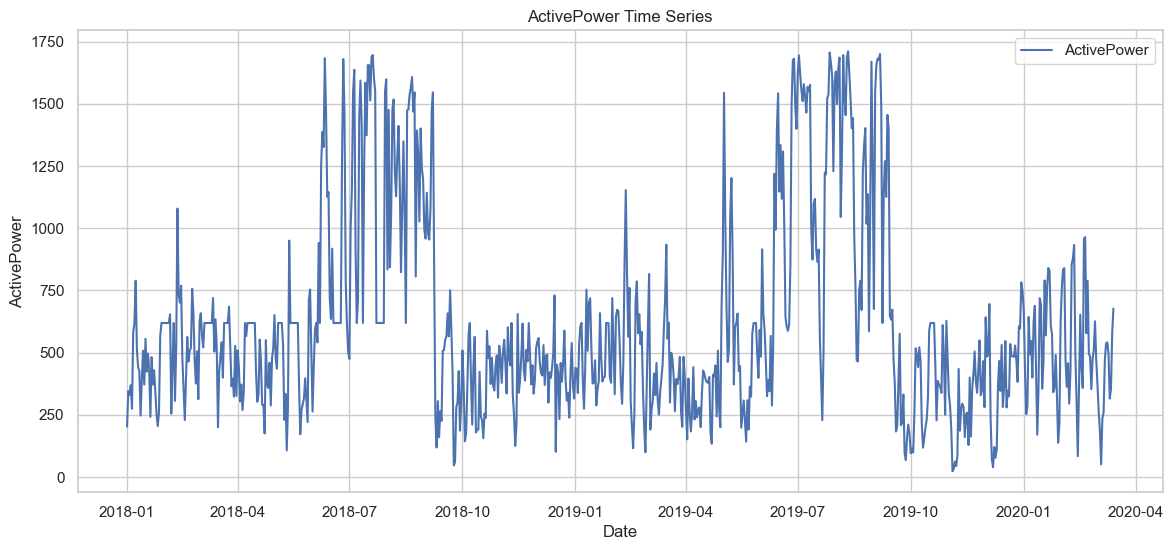

In [19]:
# Set plot style
sns.set(style="whitegrid")

# Plot ActivePower time series
plt.figure(figsize=(14, 6))
plt.plot(df_daily.index, df_daily['ActivePower'], label='ActivePower')
plt.title('ActivePower Time Series')
plt.xlabel('Date')
plt.ylabel('ActivePower')
plt.legend()
plt.show()

### Seasonal Decomposition ###  
  
In order to help guide model selection, seasonal decomposition testing will be completed to check trends, seasonality, and residuals.

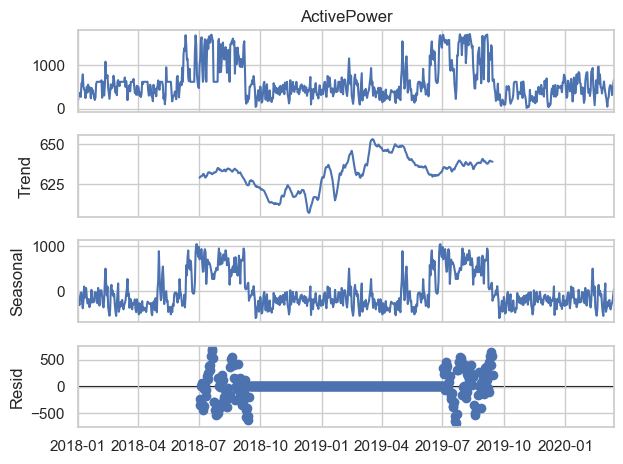

In [20]:
# Perform seasonal decomposition
decomposition = seasonal_decompose(df_daily['ActivePower'], model='additive', period=365)

# Plot the decomposition
fig = decomposition.plot()
plt.show()

## SARIMAX Modeling ###

In [21]:
# Split the dataset into train and test sets
# Calculate the split point
split_point = len(df_daily) - 15
train = df_daily[:split_point]
test = df_daily[split_point:]

### Augmented Dickey-Fuller (ADF) Test ###  
Used to check for stationarity and determine the "d" parameter in ARIMA testing models.

In [22]:
# Perform the Augmented Dickey-Fuller test
adf_test = adfuller(train['ActivePower'])

print('ADF Statistic:', adf_test[0])
print('p-value:', adf_test[1])
print('Critical Values:')
for key, value in adf_test[4].items():
    print(f'    {key}: {value}')

# Interpretation
if adf_test[1] > 0.05:
    print("The data is non-stationary and has a unit root, indicating it may need differencing.")
else:
    print("The data is stationary and does not have a unit root.")

ADF Statistic: -4.061251126923072
p-value: 0.0011216483197323374
Critical Values:
    1%: -3.438750669890019
    5%: -2.8652477937238703
    10%: -2.56874438754281
The data is stationary and does not have a unit root.


Since the data is stationary, set parameter d=0.

### ACF and PACF Visualization ###

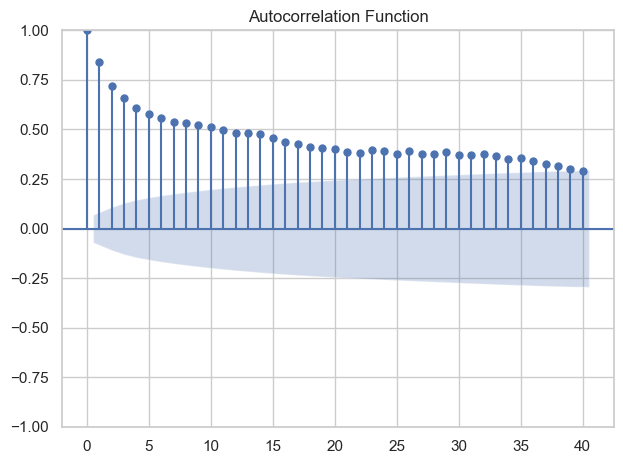

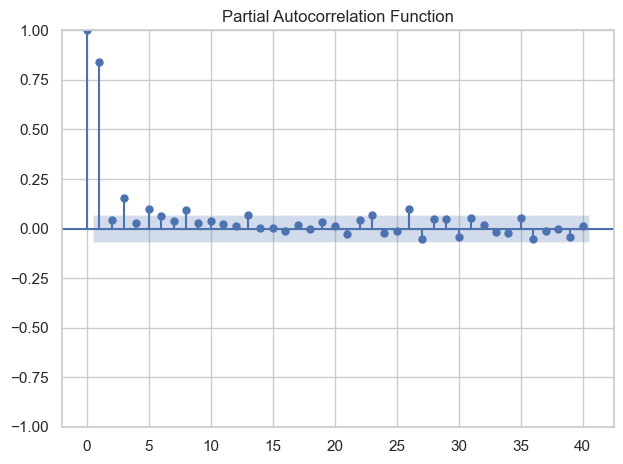

In [23]:
# First, plot and save the ACF plot
fig_acf = plt.figure(figsize=(12, 4))
plot_acf(train['ActivePower'], lags=40)
plt.title('Autocorrelation Function')
plt.tight_layout()
plt.savefig('acf_plot.png')  # Saves the ACF plot
plt.close(fig_acf)  # Close the figure to free up memory

# Next, plot and save the PACF plot
fig_pacf = plt.figure(figsize=(12, 4))
plot_pacf(train['ActivePower'], lags=40)
plt.title('Partial Autocorrelation Function')
plt.tight_layout()
plt.savefig('pacf_plot.png')  # Saves the PACF plot
plt.close(fig_pacf)  # Close the figure to free up memory

In the PACF plot, there is a significant spike at lag 1, which quickly falls within the confidence interval (the blue shaded area) for subsequent lags. This suggests that an AR(1) model might be appropriate for the data. In the SARIMA Model, set p=1.

### Auto ARIMA ###  
The first method of determining optimal parameters will be to run auto_arrima.

In [24]:
sarima_model = auto_arima(train['ActivePower'], seasonal=True, m=100, 
                          trace=True, error_action='ignore', suppress_warnings=True,
                          stepwise=True, max_p=2, max_d=2, max_q=2)

sarima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[100] intercept   : AIC=inf, Time=210.11 sec
 ARIMA(0,0,0)(0,0,0)[100] intercept   : AIC=11722.611, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[100] intercept   : AIC=10754.436, Time=19.07 sec
 ARIMA(0,0,1)(0,0,1)[100] intercept   : AIC=11129.733, Time=72.74 sec
 ARIMA(0,0,0)(0,0,0)[100]             : AIC=12677.847, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[100] intercept   : AIC=10753.028, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[100] intercept   : AIC=10754.412, Time=14.79 sec
 ARIMA(1,0,0)(1,0,1)[100] intercept   : AIC=10756.412, Time=32.31 sec
 ARIMA(2,0,0)(0,0,0)[100] intercept   : AIC=10753.650, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[100] intercept   : AIC=10752.823, Time=0.15 sec
 ARIMA(1,0,1)(1,0,0)[100] intercept   : AIC=10754.353, Time=22.19 sec
 ARIMA(1,0,1)(0,0,1)[100] intercept   : AIC=10754.499, Time=22.34 sec
 ARIMA(1,0,1)(1,0,1)[100] intercept   : AIC=10756.192, Time=40.17 sec
 ARIMA(0,0,1)(0,0,0)[100] intercept   : AIC=11165.337, Ti

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  789
Model:               SARIMAX(2, 0, 2)   Log Likelihood               -5353.743
Date:                Mon, 19 Feb 2024   AIC                          10719.485
Time:                        22:17:07   BIC                          10747.510
Sample:                    01-01-2018   HQIC                         10730.258
                         - 02-28-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      6.7776      3.994      1.697      0.090      -1.050      14.606
ar.L1          1.4660      0.073     19.993      0.000       1.322       1.610
ar.L2         -0.4770      0.070     -6.829      0.000      -0.614      -0.340
ma.L1         -0.6975      0.075     -9.356      0.000      -0.844      -0.551
ma.L2         -0.1426      0.042     -3.365      0.001      -0.226      -0.060
sigma2      4.559e+04   1805.273     25.256      0.000    4.21e+04    4.91e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               114.15
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.93   Skew:                             0.32
Prob(H) (two-sided):                  0.55   Kurtosis:                         4.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The ACF and PACF plots indicated I may need to set p=1. However, since this wasn't identified in Auto Arrima, I'm going to follow the parameters it identified.

In [26]:
# Define the endog and exog variables
endog = df_daily['ActivePower']
exog = df_daily[['WindSpeed', 'GeneratorRPM', 'RotorRPM', 'GeneratorWinding1Temperature']]

# Split the data into train and test sets
split_point = len(df_daily) - 15  # Reserve the last 15 days for testing
train_endog, test_endog = endog[:split_point], endog[split_point:]
train_exog, test_exog = exog[:split_point], exog[split_point:]

# Fit a SARIMAX model
sarimax_model = SARIMAX(train_endog, exog=train_exog, order=(2,0,2), seasonal_order=(0,0,0,100))
sarimax_model_fit = sarimax_model.fit(maxiter=500, method='powell', tol=1e-2, disp=False)

# Forecast
sarimax_forecast = sarimax_model_fit.forecast(steps=15, exog=test_exog)

In [27]:
# Calculate MAE, RMSE, and MAPE
sarimax_mae = mean_absolute_error(test_endog, sarimax_forecast)
sarimax_mse = mean_squared_error(test_endog, sarimax_forecast)
sarimax_rmse = sqrt(sarimax_mse)
sarimax_mape = mean_absolute_percentage_error(test_endog, sarimax_forecast)

sarimax_mae, sarimax_rmse, sarimax_mape

(31.023569376895356, 43.030384497261345, 0.12028836230760867)

## XGBoost with GridsearchCV ##

In [29]:
# Check the last date in the dataset to know where our forecasting should start
last_date = df_daily.index.max()

# Prepare the features (X) and target (y)
xgb_X = df_daily.drop('ActivePower', axis=1)
xgb_y = df_daily['ActivePower']

# Since this is time series forecasting, we'll use the last 30 days as a "test" set in this demonstration to validate the model
xgb_train_size = len(df_daily) - 30
xgb_X_train, xgb_X_test = xgb_X.iloc[:xgb_train_size], xgb_X.iloc[xgb_train_size:]
xgb_y_train, xgb_y_test = xgb_y.iloc[:xgb_train_size], xgb_y.iloc[xgb_train_size:]

In [ ]:
# Define the p, d, q parameters to take any value between 0 and 2
p = d = q = range(0, 3)

# Define the seasonal parameter
# For computational efficiency, using a simplified seasonality (e.g., monthly)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 365) for x in pdq]

# Placeholder for the best parameters and results
best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
best_model = None

# Grid search for the optimal SARIMA parameters
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(train,
                          order=param,
                          seasonal_order=param_seasonal,
                          enforce_stationarity=False,
                          enforce_invertibility=False)

            results = mod.fit(disp=False)
            
            # Compare this model's AIC with the best so far
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
                best_model = results
        except:
            continue

# Forecast the next 15 days
forecast = best_model.get_forecast(steps=15)
forecast_values = forecast.predicted_mean

# Calculate errors
mse = mean_squared_error(test, forecast_values)
rmse = sqrt(mse)
mape = mean_absolute_percentage_error(test, forecast_values)

best_aic, best_pdq, best_seasonal_pdq, mse, rmse, mape

In [30]:
# Define the model
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100)

# Define the grid of hyperparameters to search
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
}

# Setup GridSearchCV
xgb_grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Fit the GridSearchCV to the training data
xgb_grid_search.fit(xgb_X_train, xgb_y_train)

# Best parameters found
xgb_best_params = xgb_grid_search.best_params_
print("xgb_best_params", xgb_best_params)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
xgb_best_params {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'subsample': 1.0}


In [31]:
# Initialize the XGBoost model with the best parameters
xgb_optimal_model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    colsample_bytree=1.0,
    learning_rate=0.1,
    max_depth=5,
    subsample=1.0
)

# Train the model on the training data
xgb_optimal_model.fit(xgb_X_train, xgb_y_train)

# Predict on the test set
xgb_y_pred = xgb_optimal_model.predict(xgb_X_test)

# Calculate MAE the test set
xgb_mae = mean_absolute_error(xgb_y_test, xgb_y_pred)

print("xgb_mae", xgb_mae)

# Calculate RMSE for the test set
xgb_rmse_test = np.sqrt(mean_squared_error(xgb_y_test, xgb_y_pred))

print("xgb_rmse_test", xgb_rmse_test)

# Calculate MAPE for the test set

xgb_mape = mean_absolute_percentage_error(xgb_y_test, xgb_y_pred)
print("xgb_mape", xgb_mape)

xgb_mae 31.24954161423522
xgb_rmse_test 40.67154788747206
xgb_mape 0.09430550877546205


## LSTM Model ###

In [32]:
# Normalize the features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_daily)

# Function to create sequences
def create_sequences(data, sequence_length):
    xs, ys = [], []
    for i in range(len(data)-sequence_length):
        lstm_x = data[i:(i+sequence_length), :]
        lstm_y = data[i+sequence_length, 0] # Target is ActivePower
        xs.append(lstm_x)
        ys.append(lstm_y)
    return np.array(xs), np.array(ys)

# Define the sequence length (number of days to use for prediction)
sequence_length = 30 # Using last 30 days to predict the next day

# Create sequences
lstm_X, lstm_y = create_sequences(scaled_data, sequence_length)

# Since we're forecasting for 15 days after the dataset, we'll use the last part of the data as "test" set for evaluation
# However, for actual forecasting beyond the dataset, we'll train on the entire dataset later
lstm_train_size = int(len(lstm_X) * 0.9)
lstm_X_train, lstm_X_test = lstm_X[:lstm_train_size], lstm_X[lstm_train_size:]
lstm_y_train, lstm_y_test = lstm_y[:lstm_train_size], lstm_y[lstm_train_size:]

lstm_X_train.shape, lstm_X_test.shape, lstm_y_train.shape, lstm_y_test.shape

((696, 30, 5), (78, 30, 5), (696,), (78,))

In [33]:
# Define the LSTM Model
lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(lstm_X_train.shape[1], lstm_X_train.shape[2])),
    Dropout(0.2),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')

In [34]:
# Train the LSTM Model
history = lstm_model.fit(lstm_X_train, lstm_y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/50

20/20 [==============================] - 1s 17ms/step - loss: 0.0662 - val_loss: 0.0178
Epoch 2/50
20/20 [==============================] - 0s 8ms/step - loss: 0.0370 - val_loss: 0.0107
Epoch 3/50
20/20 [==============================] - 0s 8ms/step - loss: 0.0330 - val_loss: 0.0097
Epoch 4/50
20/20 [==============================] - 0s 8ms/step - loss: 0.0338 - val_loss: 0.0109
Epoch 5/50
20/20 [==============================] - 0s 8ms/step - loss: 0.0321 - val_loss: 0.0101
Epoch 6/50
20/20 [==============================] - 0s 8ms/step - loss: 0.0326 - val_loss: 0.0094
Epoch 7/50
20/20 [==============================] - 0s 8ms/step - loss: 0.0314 - val_loss: 0.0089
Epoch 8/50
20/20 [==============================] - 0s 8ms/step - loss: 0.0292 - val_loss: 0.0086
Epoch 9/50
20/20 [==============================] - 0s 8ms/step - loss: 0.0285 - val_loss: 0.0115
Epoch 10/50
20/20 [==============================] - 0s 9ms/step - loss: 0.0265 - val_loss: 0.0103
Epoch 11/50
20/20

In [35]:
# Make predictions
lstm_predictions = lstm_model.predict(lstm_X_test)

# Inverse transform to get actual values
lstm_y_test_actual = scaler.inverse_transform(np.concatenate((lstm_y_test.reshape(-1, 1), np.zeros((len(lstm_y_test), 4))), axis=1))[:, 0]
lstm_predictions_actual = scaler.inverse_transform(np.concatenate((lstm_predictions, np.zeros((lstm_predictions.shape[0], 4))), axis=1))[:, 0]

# Calculate MAE, RMSE, and MAPE
lstm_mae = mean_absolute_error(lstm_y_test_actual, lstm_predictions_actual)
lstm_rmse = np.sqrt(mean_squared_error(lstm_y_test_actual, lstm_predictions_actual))
lstm_mape = np.mean(np.abs((lstm_y_test_actual - lstm_predictions_actual) / lstm_y_test_actual)) * 100

print(f"LSTM MAE: {lstm_mae}, LSTM RMSE: {lstm_rmse}, LSTM MAPE: {lstm_mape}%")

3/3 [==============================] - 0s 3ms/step
LSTM MAE: 166.12701042975024, LSTM RMSE: 197.89707493603598, LSTM MAPE: 48.517090848142445%


## Model Comparison ##  

Use a table to compare MSE, RMSE, and MAPE scores for all three models to select which model to use for forecasting.

In [36]:
# Create a dictionary containing your data
table = {
    'Model': ['SARIMAX', 'XGBoosting', 'LSTM'],
    'MAE': [sarimax_mae, xgb_mae, lstm_mae],
    'RMSE': [sarimax_rmse, xgb_rmse_test, lstm_rmse],
    'MAPE': [sarimax_mape, xgb_mape, lstm_mape]
}

# Create a DataFrame from the dictionary
data_table = pd.DataFrame(table)

# Format the 'MAPE' column to append a '%' sign
data_table['MAPE'] = data_table['MAPE'].apply(lambda x: f'{x}%')

# Save the DataFrame
data_table.to_csv('metrics.csv', index=False)

# Display the data table
print(data_table)

        Model         MAE        RMSE                  MAPE
0     SARIMAX   31.023569   43.030384  0.12028836230760867%
1  XGBoosting   31.249542   40.671548  0.09430550877546205%
2        LSTM  166.127010  197.897075   48.517090848142445%


LSTM is by far the worst model. SARIMAX and XGBoosting were close, but XGBoosting had slightly better RMSE and MAPE, so I will utilize this model to forecast and visualize the ActivePower generated over the next 15 days.

## XGBoost Forecasting ##

In [37]:
# Calculate the monthly average and standard deviation for each feature
monthly_avg = df_daily.groupby(df_daily.index.month).mean()
std_dev = df_daily.std()

# Generating future values for the next 15 days
future_dates = pd.date_range(start=df_daily.index[-1] + pd.Timedelta(days=1), periods=15, freq='D')
estimated_values = {
    'WindSpeed': [],
    'GeneratorRPM': [],
    'RotorRPM': [],
    'GeneratorWinding1Temperature': []
}

for date in future_dates:
    month = date.month
    for feature in estimated_values.keys():
        seasonal_avg = monthly_avg.loc[month, feature]
        random_variation = np.random.randn() * std_dev[feature] * 0.1  # Adjust variability factor as needed
        estimated_values[feature].append(seasonal_avg + random_variation)

# Create a DataFrame for the forecast period with estimated values
forecast_features_df = pd.DataFrame(estimated_values, index=future_dates)

# Display the DataFrame with estimated values for the forecast period
forecast_features_df

,WindSpeed,GeneratorRPM,RotorRPM,GeneratorWinding1Temperature
2020-03-15 00:00:00+00:00,5.202357,1052.529526,9.398856,69.613543
2020-03-16 00:00:00+00:00,5.259962,992.326359,9.178389,69.054255
2020-03-17 00:00:00+00:00,5.133834,1032.912107,9.282755,70.706201
2020-03-18 00:00:00+00:00,5.019829,1017.559139,9.702063,67.622139
2020-03-19 00:00:00+00:00,5.442206,1028.447545,9.314348,72.461830
2020-03-20 00:00:00+00:00,5.258602,995.223702,9.343559,68.433636
2020-03-21 00:00:00+00:00,5.034691,1034.573716,9.258921,67.791609
2020-03-22 00:00:00+00:00,5.055148,1049.713539,8.701584,67.050186
2020-03-23 00:00:00+00:00,5.263217,1008.290726,9.234317,67.307522
2020-03-24 00:00:00+00:00,5.416009,1052.121753,9.176540,69.395585


In [ ]:
# Calculate the monthly average and standard deviation for each feature
monthly_avg = df_daily.groupby(df_daily.index.month).mean()
std_dev = df_daily.std()

# Generating future values for the next 15 days
future_dates = pd.date_range(start=df_daily.index[-1] + pd.Timedelta(days=1), periods=15, freq='D')
estimated_values = {
    'WindSpeed': [],
    'GeneratorRPM': [],
    'RotorRPM': [],
    'GeneratorWinding1Temperature': []
}

for date in future_dates:
    month = date.month
    for feature in estimated_values.keys():
        seasonal_avg = monthly_avg.loc[month, feature]
        random_variation = np.random.randn() * std_dev[feature] * 0.1  # Adjust variability factor as needed
        estimated_values[feature].append(seasonal_avg + random_variation)

# Create a DataFrame for the forecast period with estimated values
forecast_features_df = pd.DataFrame(estimated_values, index=future_dates)

# Display the DataFrame with estimated values for the forecast period
forecast_features_df

In [38]:
# Save the forecast_features_df data set for future use.
forecast_features_df.to_csv('forecast_features_df.csv', index=True)

In [39]:
# Predict 'ActivePower' for the next 15 days
predicted_active_power = xgb_optimal_model.predict(forecast_features_df)

# Create a DataFrame to display the predictions with dates
predictions_df = pd.DataFrame({
    'Date': future_dates,
    'PredictedActivePower': predicted_active_power
}).set_index('Date')

In [40]:
# Display the predictions
print(predictions_df)

                           PredictedActivePower
Date                                           
2020-03-15 00:00:00+00:00            461.310577
2020-03-16 00:00:00+00:00            471.065948
2020-03-17 00:00:00+00:00            434.782043
2020-03-18 00:00:00+00:00            393.352783
2020-03-19 00:00:00+00:00            501.332001
2020-03-20 00:00:00+00:00            466.809540
2020-03-21 00:00:00+00:00            420.839203
2020-03-22 00:00:00+00:00            412.269165
2020-03-23 00:00:00+00:00            450.785034
2020-03-24 00:00:00+00:00            494.147400
2020-03-25 00:00:00+00:00            441.612732
2020-03-26 00:00:00+00:00            460.471619
2020-03-27 00:00:00+00:00            390.850586
2020-03-28 00:00:00+00:00            428.932037
2020-03-29 00:00:00+00:00            468.067078


## Visualize the Results ##

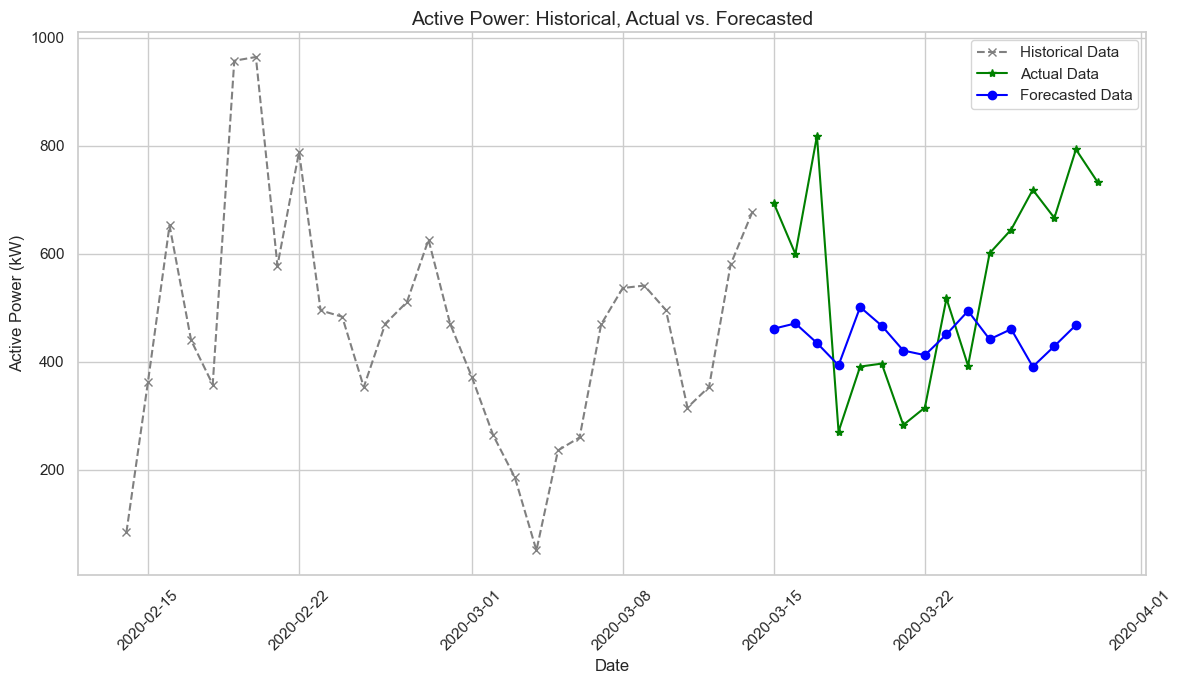

In [41]:
# Plot the last 30 days of historical ActivePower values for context
N = 30  # Adjust based on how much historical context you want to show
historical_data_to_plot = df_daily['ActivePower'][-N:]

plt.figure(figsize=(12, 7))  # Set the figure size for better visibility

# Plot historical data
plt.plot(historical_data_to_plot.index, historical_data_to_plot, marker='x', linestyle='--', color='gray', label='Historical Data')

# Plot the actual reserved data
plt.plot(last_15_days_data.index, last_15_days_data['ActivePower'], marker='*', linestyle='-', color='green', label='Actual Data')

# Plot the forecasted data
plt.plot(predictions_df.index, predictions_df['PredictedActivePower'], marker='o', linestyle='-', color='blue', label='Forecasted Data')

# Add formatting
plt.title('Active Power: Historical, Actual vs. Forecasted', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Active Power (kW)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()

# Save the figure
plt.savefig('forecast_comparison.png', dpi=300)  # Adjust filename and DPI as needed

plt.show()

In [42]:
# Sum of Actual ActivePower for the last 15 days
sum_actual_active_power = last_15_days_data['ActivePower'].sum()

# Sum of Forecasted ActivePower for the last 15 days using XGBoost
sum_forecasted_active_power = predictions_df['PredictedActivePower'].sum()

# Display the results
print(f"Sum of Actual ActivePower: {sum_actual_active_power}")
print(f"Sum of Forecasted ActivePower: {sum_forecasted_active_power}")


Sum of Actual ActivePower: 8836.047383400117
Sum of Forecasted ActivePower: 6696.6279296875


## Final Observations ##  
My XGBoost model forecasted 2,139.419453712617 units less ActivePower than were actually generated over the last 15 days of the model.  
As a first attempt at time series analysis, this project was informative and gives several paths of further learning to persue.  
Moving forward with this project, I would further adjust the parameters of all models, but especially the SARIMAX and XGBoost models since their metrics were most similar, and had the most computational challenges.